# Appendix A

In [ ]:
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import galcheat
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pdf2image import convert_from_path

from madness_benchmark.utils import get_benchmark_config_path

mpl.rcParams["text.usetex"] = True
mpl.rcParams["savefig.dpi"] = 1200

%matplotlib inline

In [ ]:
with open(get_benchmark_config_path()) as f:
    benchmark_config = yaml.safe_load(f)
btksims_config = benchmark_config["btksims"]
survey_name = benchmark_config["survey_name"]
survey = galcheat.get_survey(benchmark_config["survey_name"])

In [ ]:
data_path = os.path.join(benchmark_config["RESULTS_PATH"][survey_name], "high_density")
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
madness_results = []
debvader_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    debvader_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")
        )
    )
    scarlet_results.append(
        pd.read_pickle(
            os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")
        )
    )

    actual_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")
        )
    )
    blended_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "blended_photometry", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r"\textsc{scarlet}"
madness_plot_label = r"\texttt{MADNESS}"
debvader_plot_label = r"\texttt{VAE-deblender}"

## Metrics across all bands: Aperture photometry

In [ ]:
sns.set_theme(
    font_scale=1.75,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)
for mask_type in ["masked", "unmasked"]:

    for band in survey.available_filters:

        plt.figure(figsize=(8, 5))
        bins = np.arange(-1, 1, 0.0001)
        mask = np.ones(len(madness_results), dtype=bool)
        if mask_type == "masked":
            mask = (
                actual_photometry[band + "_phot_flux"].values
                / actual_photometry[band + "_phot_fluxerrs"].values
            ) > 5

        sns.histplot(
            np.abs(
                blended_photometry[band + "_phot_flux"].values[mask]
                / actual_photometry[band + "_phot_flux"].values[mask]
                - 1
            ),
            bins=bins,
            stat="density",
            alpha=0.05,
            cumulative=True,
            color=blended_plot_color,
            ls=blended_plot_ls,
            linewidth=2,
            element="step",
            label="No deblending",
        )

        x = sns.histplot(
            np.abs(
                madness_results[band + "_phot_flux"].values[mask]
                / actual_photometry[band + "_phot_flux"].values[mask]
                - 1
            ),
            bins=bins,
            stat="density",
            alpha=0.05,
            cumulative=True,
            color=madness_plot_color,
            element="step",
            ls=madness_plot_ls,
            linewidth=2,
            label=madness_plot_label,
        )
        # plt.plot([], [], ls=madness_plot_ls, lw=2, color=madness_plot_color, label=madness_plot_label)

        sns.histplot(
            np.abs(
                scarlet_results[band + "_phot_flux"].values[mask]
                / actual_photometry[band + "_phot_flux"].values[mask]
                - 1
            ),
            bins=bins,
            stat="density",
            alpha=0.05,
            cumulative=True,
            color=scarlet_plot_color,
            element="step",
            linewidth=2,
            ls=scarlet_plot_ls,
            label=scarlet_plot_label,
        )
        # plt.plot([], [], ls=scarlet_plot_ls, lw=2, color=scarlet_plot_color, label=scarlet_plot_label)

        # plt.plot([], [], ls=blended_plot_ls, lw=2, color=blended_plot_color, label="blended")

        sns.histplot(
            np.abs(
                debvader_results[band + "_phot_flux"].values[mask]
                / actual_photometry[band + "_phot_flux"].values[mask]
                - 1
            ),
            bins=bins,
            stat="density",
            alpha=0.05,
            cumulative=True,
            color=debvader_plot_color,
            element="step",
            ls=debvader_plot_ls,
            linewidth=2,
            label=debvader_plot_label,
        )
        # plt.plot([], [], ls=debvader_plot_ls, lw=2, color=debvader_plot_color, label=debvader_plot_label)

        ax = plt.gca()
        ax.xaxis.tick_bottom()
        ax.yaxis.tick_left()
        # ax.grid(color='lightgray', linestyle='-', linewidth=2)
        plt.xlim([0, 0.1])
        plt.ylim([0.0, 1])
        plt.xlabel(r"$|\delta F/F|$")
        plt.ylabel("cumulative fraction")

        plt.legend(
            title=rf"\textit{{{band}}}-band", loc="lower right", title_fontsize=25
        )

        plt.tight_layout()
        current_name_extension = "masked_" if mask_type == "masked" else ""

        plt.savefig(
            os.path.join(
                "results",
                "temp",
                "cumulative_distib_phot_err_" + current_name_extension + band + ".pdf",
            ),
            format="pdf",
            bbox_inches="tight",
        )

        plt.close()

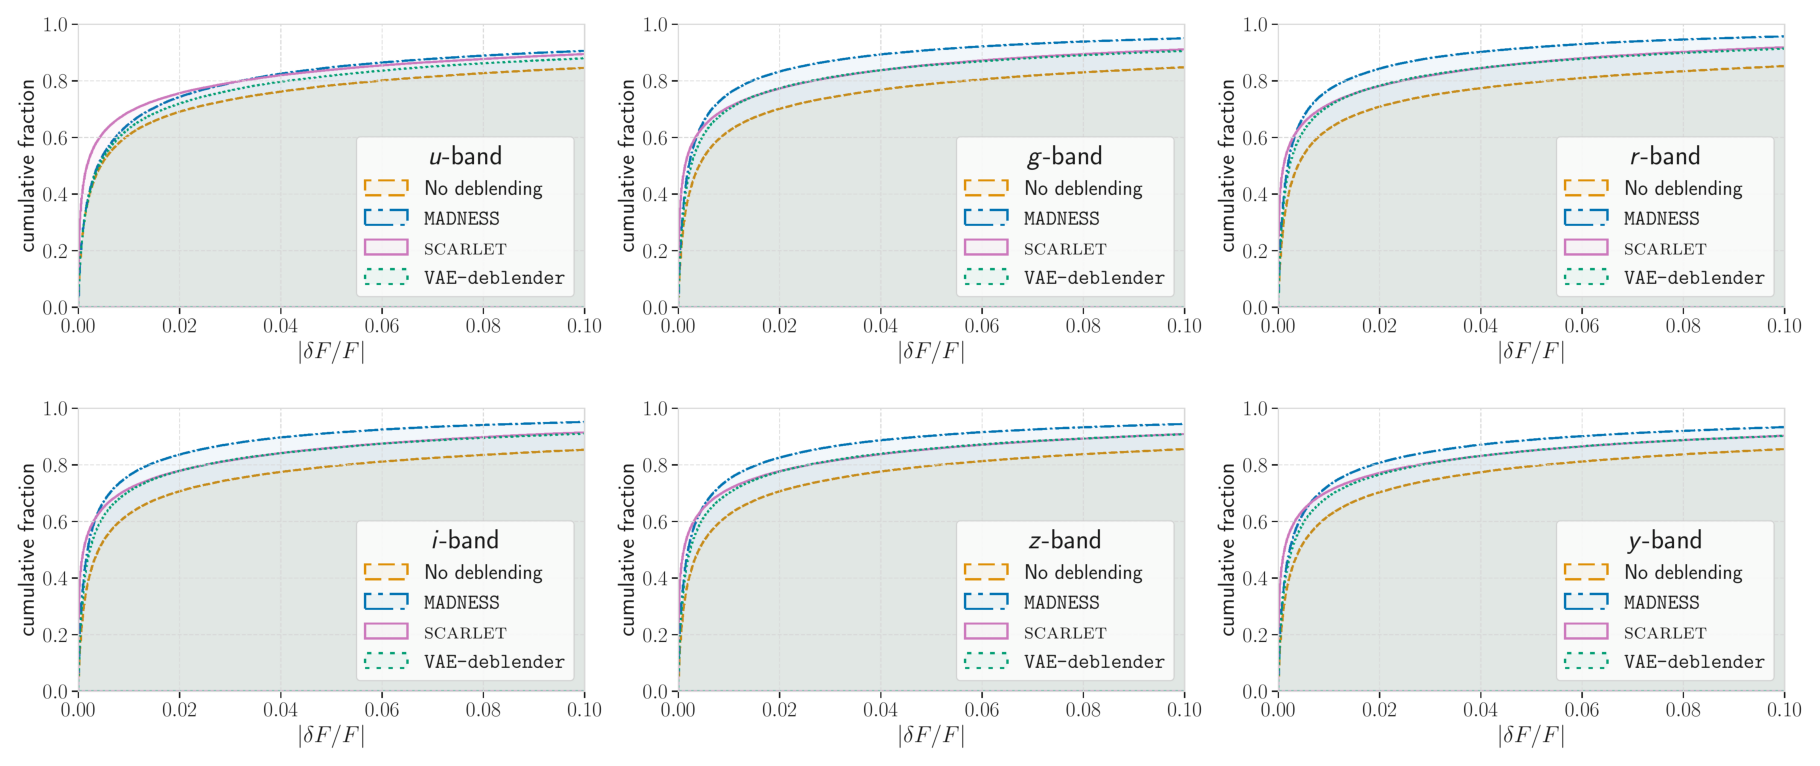

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(18, 8))

for band_num, band in enumerate(survey.available_filters):
    # axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
    axarr[int(band_num / 3)][band_num % 3].imshow(
        convert_from_path(
            os.path.join(
                "results",
                "temp",
                f"cumulative_distib_phot_err_{band}.pdf",
            )
        )[0]
    )

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)


plt.savefig(
    os.path.join("results", "cumulative_distib_phot_err.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.savefig(os.path.join("results", "temp", "cumulative_distib_phot_err.png"))

plt.show()

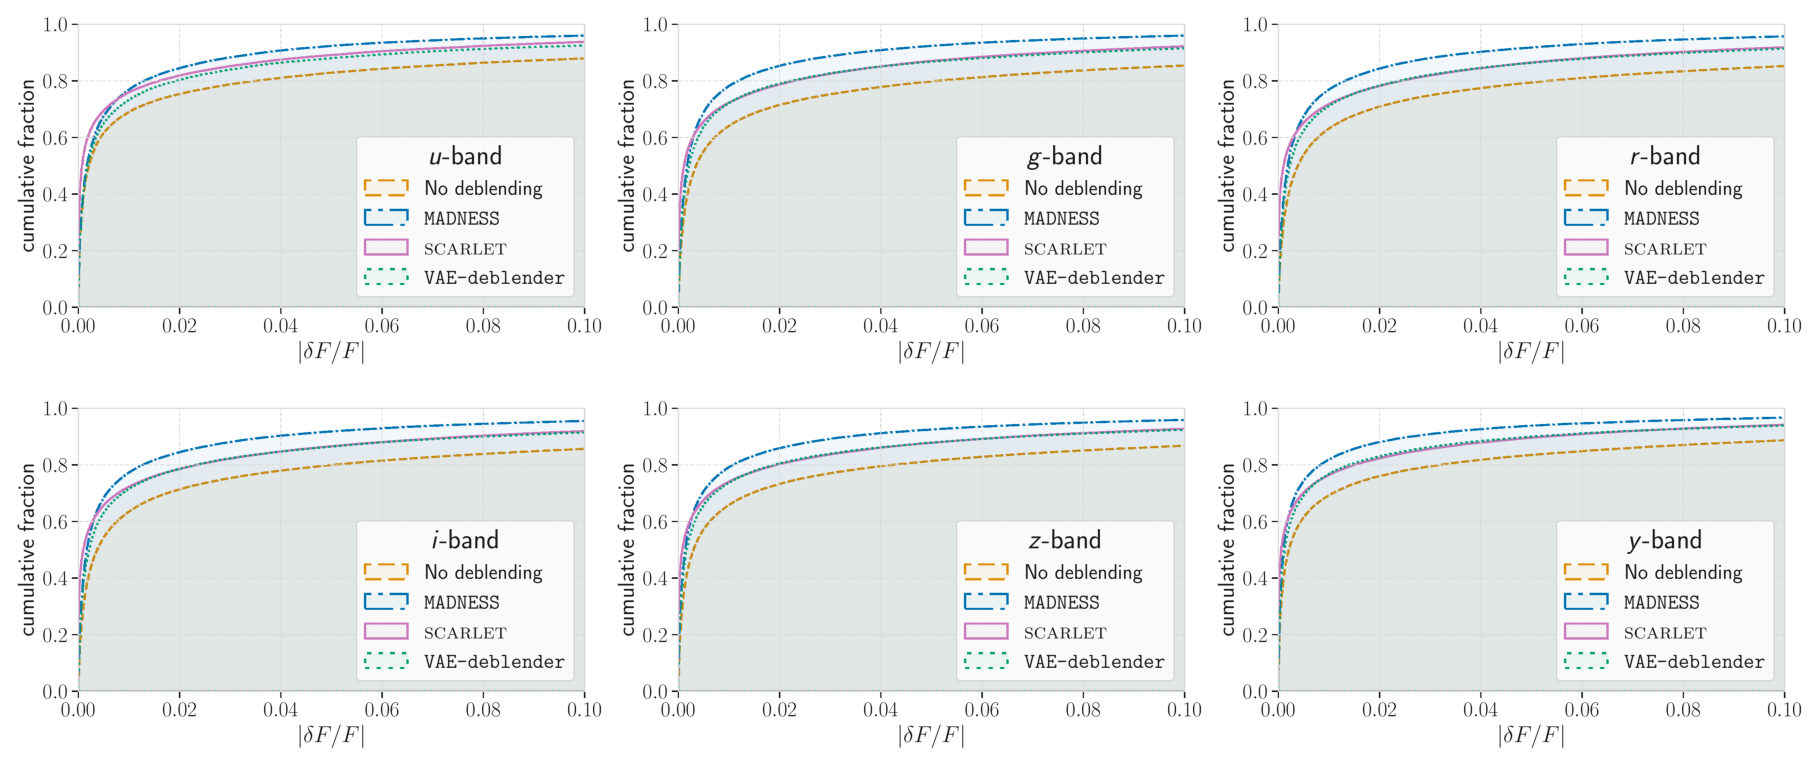

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(18, 8))

for band_num, band in enumerate(survey.available_filters):
    # axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
    axarr[int(band_num / 3)][band_num % 3].imshow(
        convert_from_path(
            os.path.join(
                "results",
                "temp",
                f"cumulative_distib_phot_err_masked_{band}.pdf",
            )
        )[0]
    )

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)


plt.savefig(
    os.path.join("results", "cumulative_distib_phot_err_masked.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()

## Metrics across all bands: Cosine distance

In [ ]:
sns.set_theme(
    font_scale=1.75,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)
bins = np.arange(-1, 1, 0.0002)
text_cos = r"\text{cos}"
for mask_type in ["masked", "unmasked"]:
    for band_number, band in enumerate(survey.available_filters):
        plt.figure(figsize=(8, 5))
        sns.set(font_scale=1.75)
        sns.set_style("whitegrid", {"grid.color": ".85", "grid.linestyle": "--"})
        if mask_type == "masked":
            mask = (
                actual_photometry[band + "_phot_flux"].values
                / actual_photometry[band + "_phot_fluxerrs"].values
            ) > 5
        else:
            mask = np.ones(len(madness_results), dtype=bool)
        sns.histplot(
            1 - madness_results[mask][band + "_ssim"].values,
            bins=bins,
            alpha=0.05,
            label=madness_plot_label,
            color=madness_plot_color,
            element="poly",
            cumulative=True,
            stat="probability",
            ls=madness_plot_ls,
            lw=2,
        )

        sns.histplot(
            1 - scarlet_results[mask][band + "_ssim"].values,
            bins=bins,
            alpha=0.05,
            label=scarlet_plot_label,
            color=scarlet_plot_color,
            element="poly",
            cumulative=True,
            stat="probability",
            ls=scarlet_plot_ls,
            lw=2,
        )
        sns.histplot(
            1 - debvader_results[mask][band + "_ssim"].values,
            bins=bins,
            alpha=0.05,
            label=debvader_plot_label,
            color=debvader_plot_color,
            element="poly",
            cumulative=True,
            stat="probability",
            ls=debvader_plot_ls,
            lw=2,
        )

        # plt.legend(title= fr"\textit{{{band}}}-band", loc="upper left", fontsize=15)
        ax = plt.gca()

        ax.xaxis.tick_bottom()
        ax.yaxis.tick_left()
        plt.xlim([0.0, 0.01])
        plt.ylim([0, 1])
        plt.xlabel(r"$1-{\mathrm{SSIM}}$")
        plt.ylabel("cumulative fraction")

        plt.tight_layout()
        current_name_extension = "masked_" if mask_type == "masked" else ""

        plt.legend(title=rf"\textit{{{band}}}-band", loc="lower right", fontsize=15)

        plt.savefig(
            os.path.join(
                "results",
                "temp",
                "ssim_res_" + current_name_extension + band + ".pdf",
            ),
            format="pdf",
            bbox_inches="tight",
        )
        plt.close()

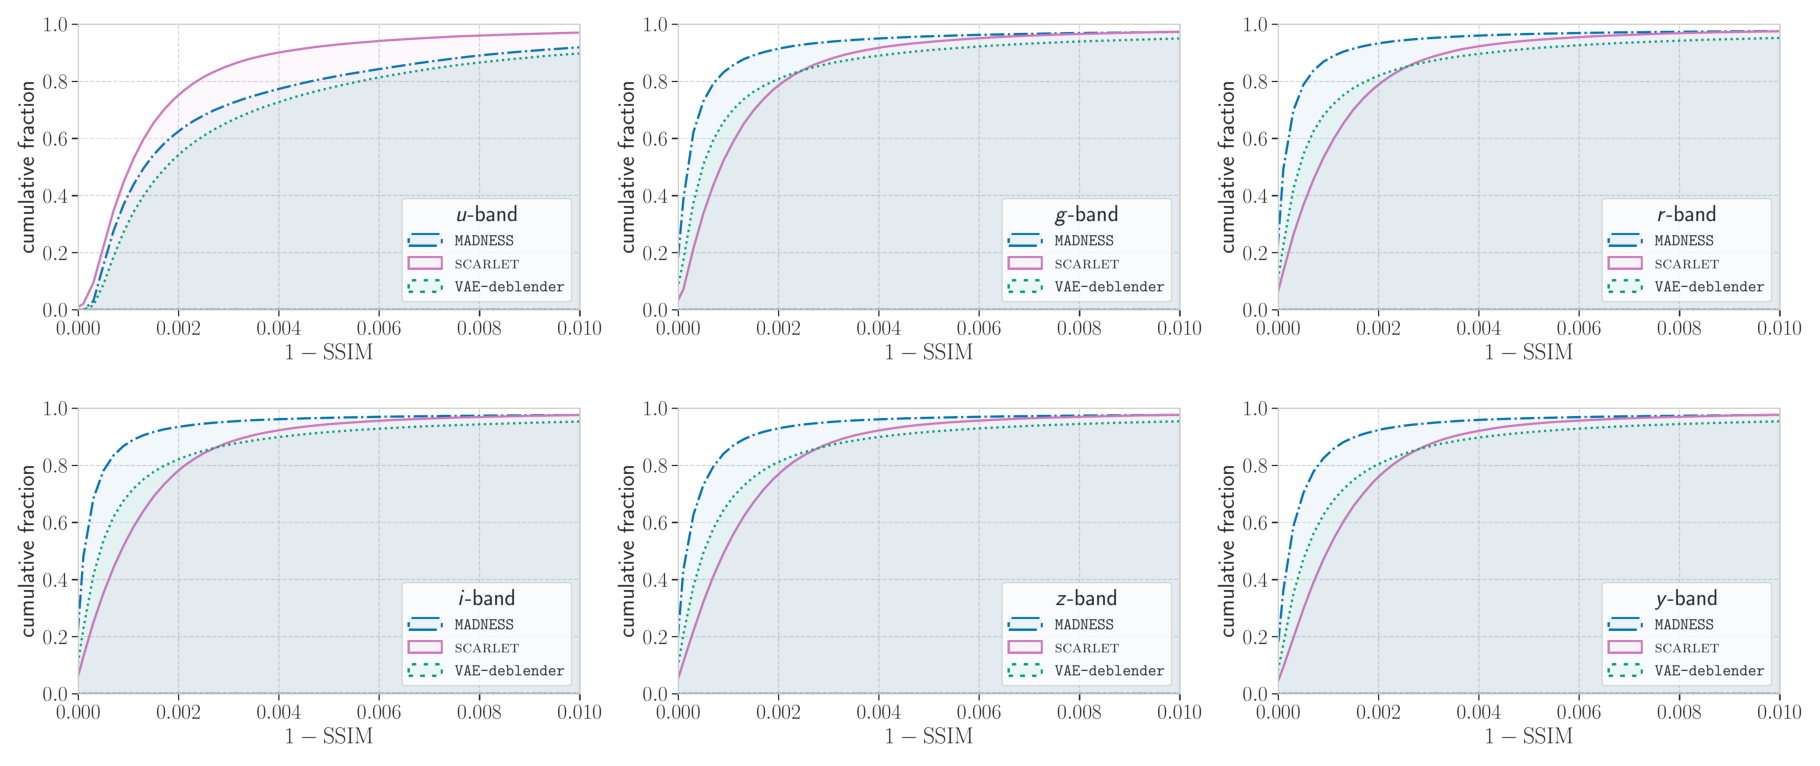

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(18, 8))

for band_num, band in enumerate(survey.available_filters):
    # axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))

    axarr[int(band_num / 3)][band_num % 3].imshow(
        convert_from_path(
            os.path.join(
                "results",
                "temp",
                f"ssim_res_{band}.pdf",
            )
        )[0]
    )

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)


plt.savefig(
    os.path.join("results", "ssim_res.pdf"),
    format="pdf",
    bbox_inches="tight",
)
plt.show()

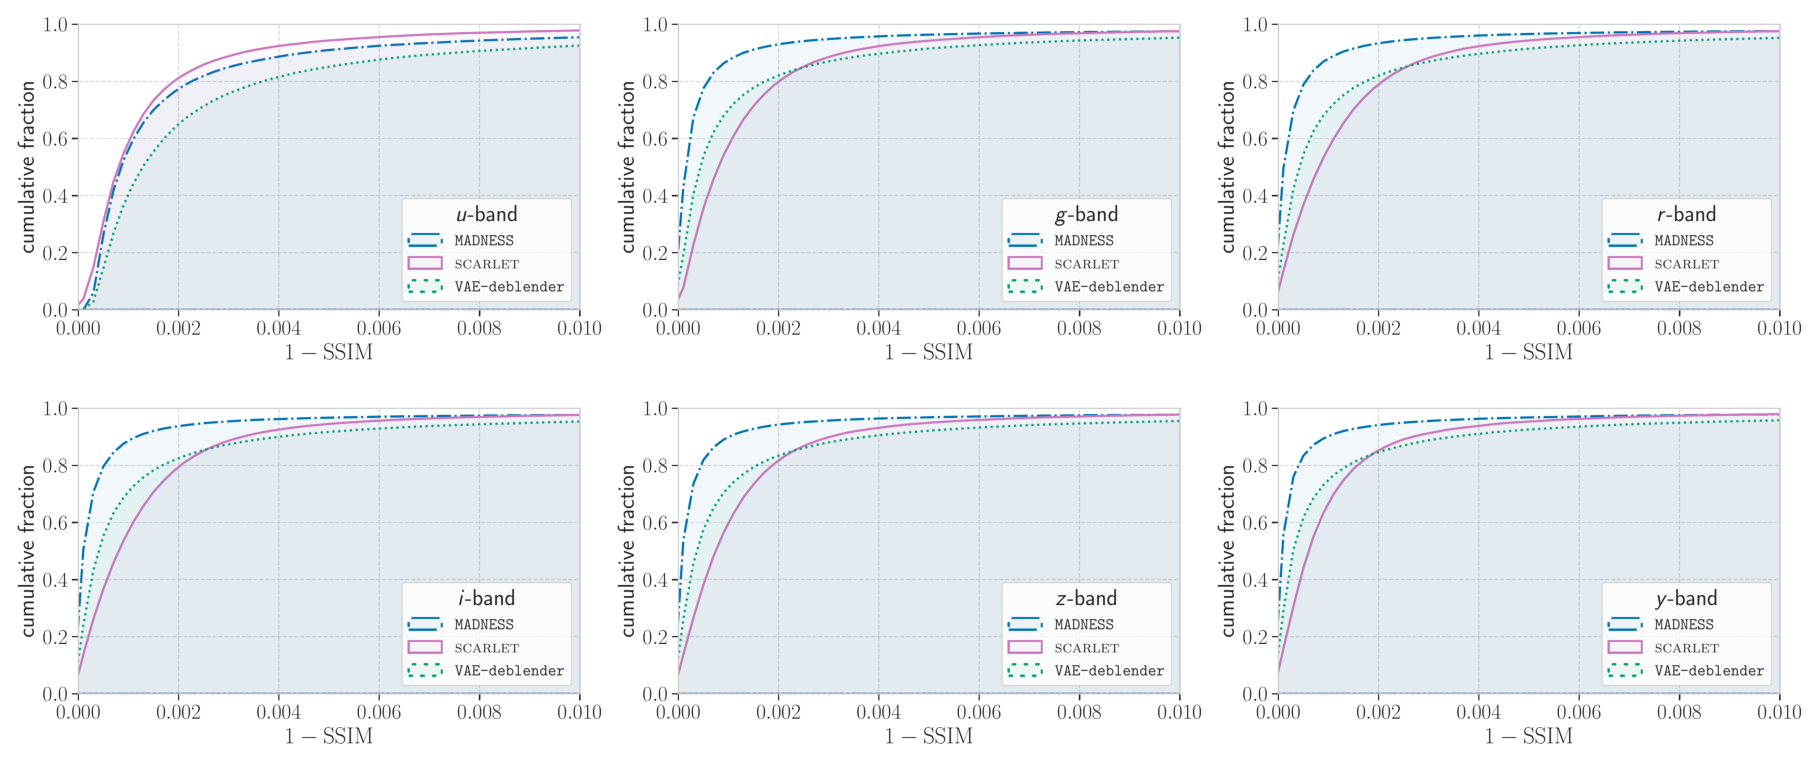

In [ ]:
f, axarr = plt.subplots(2, 3, figsize=(18, 8))

for band_num, band in enumerate(survey.available_filters):
    # axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))

    axarr[int(band_num / 3)][band_num % 3].imshow(
        convert_from_path(
            os.path.join(
                "results",
                "temp",
                f"ssim_res_masked_{band}.pdf",
            )
        )[0]
    )

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)


plt.savefig(
    os.path.join("results", "ssim_res_masked.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()